# Employee Retention Analysis

- Nama: Nantha Seutia
- Email: ombakrinai@gmail.com
- Id Dicoding: ombakrinai@gmail.com

## Data Gathering

### Menyiapkan library yang dibutuhkan

In [ ]:
# ==================== IMPORT LIBRARY ====================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report

from scipy.stats import pearsonr, spearmanr, ttest_ind, chi2_contingency

import requests
import math

### Menyiapkan data yang akan digunakan

In [ ]:
# ==================== DATA GATHERING ====================
url = "https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/employee/employee_data.csv"
local_path = "employee_data.csv"

# Download and save the dataset
with open(local_path, 'wb') as f:
    f.write(requests.get(url).content)

df = pd.read_csv(local_path, encoding="utf-8")
df.head()

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,NaN,Travel_Frequently,1444,Human Resources,1,4,Other,1,...,2,80,1,7,2,3,6,2,1,2
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
4,5,40,NaN,Travel_Rarely,1194,Research & Development,2,4,Medical,1,...,2,80,3,20,2,3,5,3,0,2


## Data Understanding

In [ ]:
print(f"📊 Dataset: {df.shape[0]} rows, {df.shape[1]} columns\n")
print("🧾 Columns:", ", ".join(df.columns), "\n")
print(f"🔁 Duplicate rows: {df.duplicated().sum()}")
missing = df.isnull().sum()[df.isnull().sum() > 0]
if not missing.empty:
    print("⚠️ Columns with missing values:")
    print(missing)
else:
    print("✅ No missing values in dataset.")

df.info()


📊 Dataset: 1470 rows, 35 columns

🧾 Columns: EmployeeId, Age, Attrition, BusinessTravel, DailyRate, Department, DistanceFromHome, Education, EducationField, EmployeeCount, EnvironmentSatisfaction, Gender, HourlyRate, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, MonthlyIncome, MonthlyRate, NumCompaniesWorked, Over18, OverTime, PercentSalaryHike, PerformanceRating, RelationshipSatisfaction, StandardHours, StockOptionLevel, TotalWorkingYears, TrainingTimesLastYear, WorkLifeBalance, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager 

🔁 Duplicate rows: 0
⚠️ Columns with missing values:
Attrition    412
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 

* Kolom Attrition hanya memiliki 1058 non-null dari 1470 → hilang sebanyak 412 entri.
* Perlu pemeriksaan apakah data hilang berkaitan dengan korelasi tertentu atau acak.
* Satu kolom numerik float: Attrition (seharusnya biner: 0 atau 1) bisa dikonversi ke int.
* 8 kolom kategorikal: object → perlu encoding pada tahap Data Preparation.

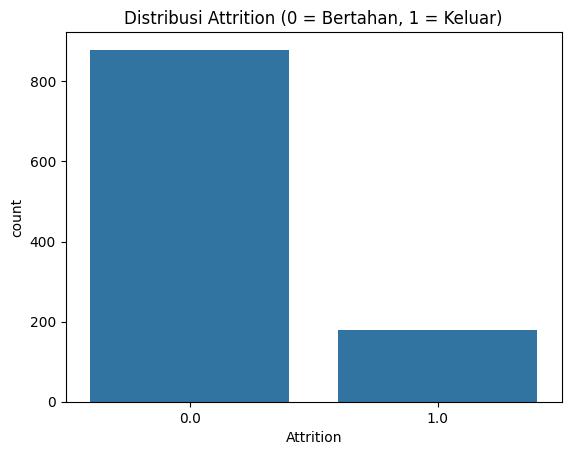

,count
Attrition,
0.0,879
NaN,412
1.0,179


In [ ]:
# ==================== DATA EXPLORATION ====================
# Mengecek Distribusi Target
sns.countplot(data=df, x="Attrition")
plt.title("Distribusi Attrition (0 = Bertahan, 1 = Keluar)")
plt.show()

df["Attrition"].value_counts(dropna=False)

* Dataset tidak seimbang. Perlu penanganan khusus di tahap modeling: misalnya dengan resampling, class weighting, dsb.
* 28% missing pada target harus ditangani sebelum modeling.

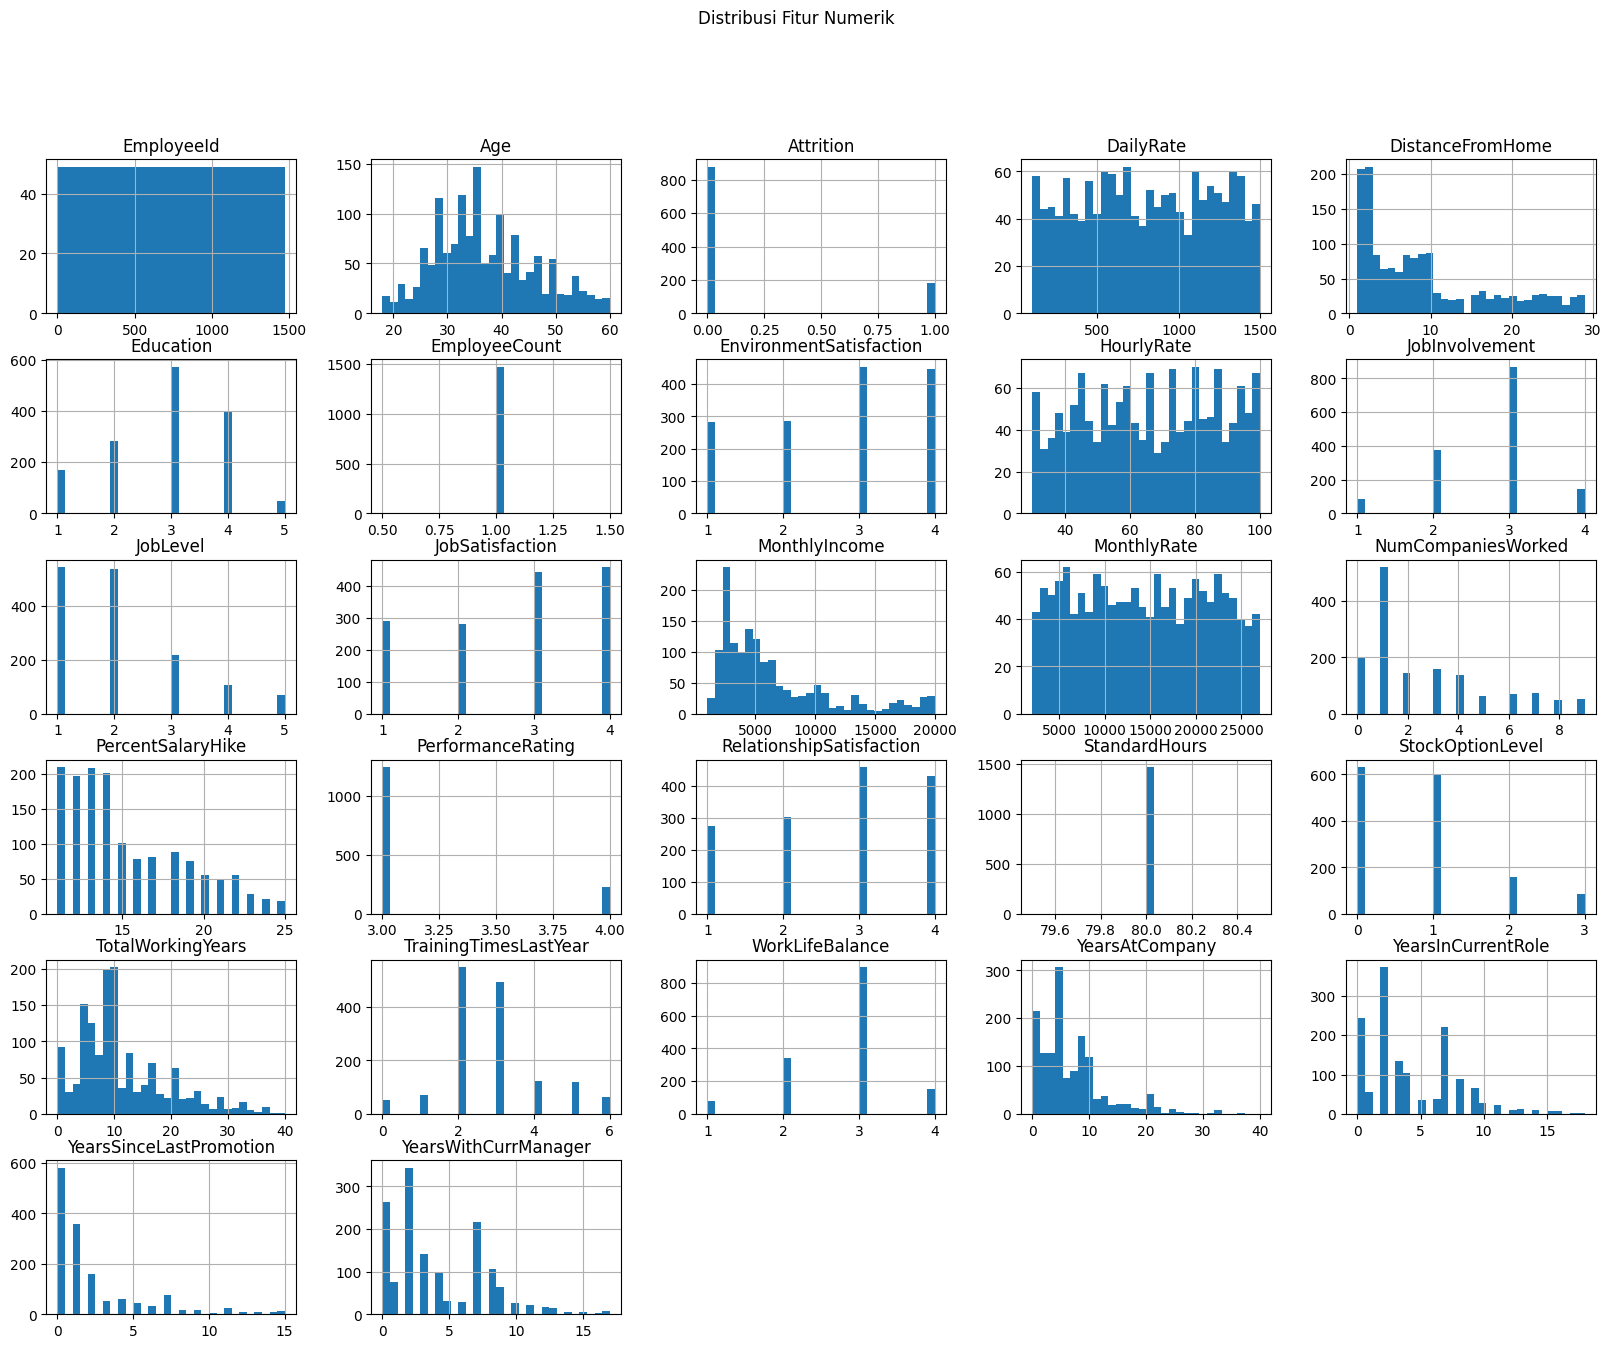

In [ ]:
# Distribusi Target & Fitur Numerik
df.hist(figsize=(20, 15), bins=30)
plt.suptitle("Distribusi Fitur Numerik")
plt.show()

* Distribusi merata: Age, HourlyRate, MonthlyRate, DailyRate, PercentSalaryHike
* Distribusi skewed: DistanceFromHome, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager, YearsInCurrentRole
* Distribusi skewed tinggi: MonthlyIncome, TotalWorkingYears




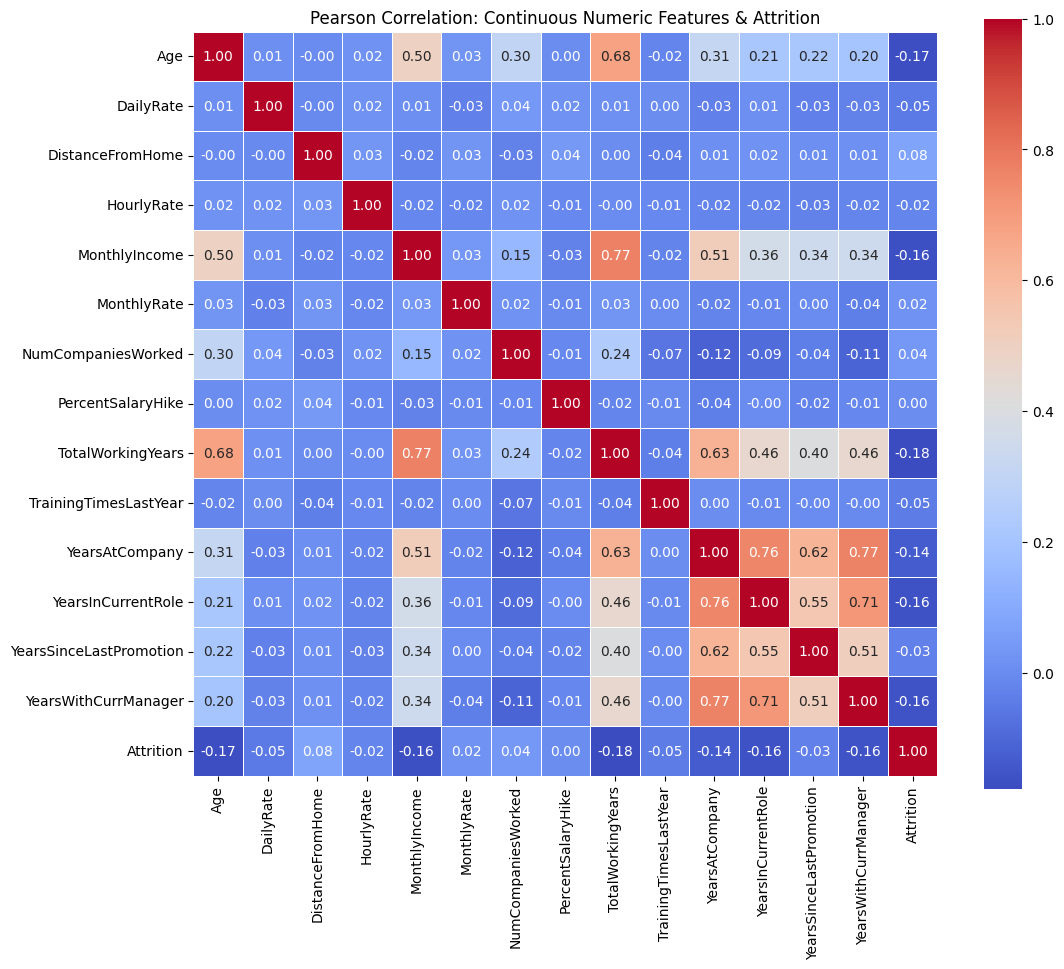

Pearson correlations with Attrition (continuous features):
DistanceFromHome           0.078074
NumCompaniesWorked         0.037429
MonthlyRate                0.023299
PercentSalaryHike          0.004907
HourlyRate                -0.017524
YearsSinceLastPromotion   -0.031944
TrainingTimesLastYear     -0.047859
DailyRate                 -0.051992
YearsAtCompany            -0.135134
YearsWithCurrManager      -0.155962
YearsInCurrentRole        -0.158757
MonthlyIncome             -0.163600
Age                       -0.172067
TotalWorkingYears         -0.177137
Name: Attrition, dtype: float64


In [ ]:
# Heatmap korelasi numerik
# * Melihat kekuatan hubungan antar fitur
# * Menilai fitur apa yang berpengaruh terhadap target (Attrition)
numeric_features = [
    'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
    'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
    'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]
pearson_corr = df[numeric_features + ["Attrition"]].corr(method="pearson")
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)
plt.title("Pearson Correlation: Continuous Numeric Features & Attrition")
plt.show()
print("Pearson correlations with Attrition (continuous features):")
print(pearson_corr["Attrition"].drop("Attrition").sort_values(ascending=False))

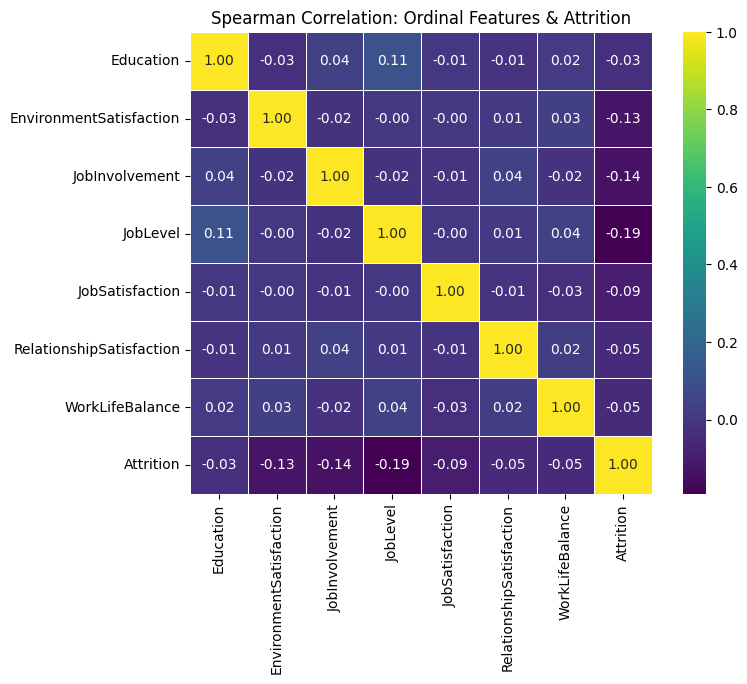


Spearman correlations with Attrition (ordinal features):
Education                  -0.028035
RelationshipSatisfaction   -0.047818
WorkLifeBalance            -0.048500
JobSatisfaction            -0.094402
EnvironmentSatisfaction    -0.126702
JobInvolvement             -0.136588
JobLevel                   -0.191820
Name: Attrition, dtype: float64


In [ ]:
# Korelasi ordinal
ordinal_features = [
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance'
]
spearman_corr = df[ordinal_features + ["Attrition"]].corr(method="spearman")
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="viridis", square=True, linewidths=.5)
plt.title("Spearman Correlation: Ordinal Features & Attrition")
plt.show()
print("\nSpearman correlations with Attrition (ordinal features):")
print(spearman_corr["Attrition"].drop("Attrition").sort_values(ascending=False))

1. JobLevel (meskipun tidak sangat kuat) berkorelasi semakin tinggi jabatan, makin kecil kemungkinan keluar.

In [ ]:
# ATTRITION RATE BY CATEGORICAL FEATURE
# Menampilkan rata-rata attrition untuk setiap kategori dari fitur kategorikal.
# Memetakan fitur mana yang berpotensi menjadi “early warning” atau sasaran intervensi HR.
# Memberi insight awal sebelum analisis lebih lanjut (seperti modeling).

categorical = ['BusinessTravel','Department','EducationField','Gender','MaritalStatus','OverTime']

print("=== ATTRITION RATE by Categorical Feature ===\n")
for cat in categorical:
    pivot = df.groupby(cat)['Attrition'].mean().sort_values(ascending=False)
    print(f"[{cat}]\n{pivot.to_string()}\n{'-'*50}")

=== ATTRITION RATE by Categorical Feature ===

[BusinessTravel]
BusinessTravel
Travel_Frequently    0.248780
Travel_Rarely        0.156836
Non-Travel           0.102804
--------------------------------------------------
[Department]
Department
Sales                     0.206897
Human Resources           0.157895
Research & Development    0.152639
--------------------------------------------------
[EducationField]
EducationField
Technical Degree    0.260417
Marketing           0.213115
Other               0.169492
Life Sciences       0.160550
Medical             0.139394
Human Resources     0.133333
--------------------------------------------------
[Gender]
Gender
Male      0.174194
Female    0.162100
--------------------------------------------------
[MaritalStatus]
MaritalStatus
Single      0.267045
Married     0.133621
Divorced    0.095041
--------------------------------------------------
[OverTime]
OverTime
Yes    0.319218
No     0.107856
------------------------------------------

1. Semakin sering dinas, semakin besar peluang karyawan keluar.
2. Karyawan Sales lebih rentan keluar dibanding departemen lain.
3. Latar belakang pendidikan teknis/marketing cenderung lebih sering keluar.
4. Tidak ada perbedaan signifikan antara pria dan wanita.
5. Karyawan lajang paling rawan keluar.
6. Lembur tinggi = risiko keluar makin tinggi.

In [ ]:
# CHI-SQUARE TES
# 1. Menguji hubungan/keterkaitan antara dua variabel kategorikal
#     (misal: apakah ‘OverTime’ berhubungan dengan ‘Attrition’).
# 2. Nilai chi-square: mengukur seberapa besar deviasi antara distribusi
#     yang diamati vs distribusi yang diharapkan jika tidak ada hubungan.
#     p-value: jika < 0.05 → ada hubungan yang signifikan secara statistik.

print("\n=== CHI-SQUARE TEST (Korelasi Fitur Kategorikal vs Attrition) ===\n")
for cat in categorical:
    ct = pd.crosstab(df[cat], df['Attrition'])
    chi2, p, _, _ = chi2_contingency(ct)
    print(f"{cat:15} | chi2={chi2:7.2f} | p-value={p:.4f}")


=== CHI-SQUARE TEST (Korelasi Fitur Kategorikal vs Attrition) ===

BusinessTravel  | chi2=  13.40 | p-value=0.0012
Department      | chi2=   4.63 | p-value=0.0989
EducationField  | chi2=   9.81 | p-value=0.0808
Gender          | chi2=   0.19 | p-value=0.6646
MaritalStatus   | chi2=  37.62 | p-value=0.0000
OverTime        | chi2=  67.76 | p-value=0.0000


1. **BusinessTravel, MaritalStatus, OverTime.** berkorelasi dengan attrition rate tinggi.
    * p-value sangat kecil (<0.05), artinya ada hubungan kuat antara fitur ini dengan Attrition (layak masuk analisis/model lebih lanjut).

2. **Department, EducationField, Gender.**
    * p-value lebih dari 0.05 → tidak ada bukti hubungan yang signifikan antara fitur tersebut dan Attrition (boleh dipertimbangkan untuk di-drop dari model untuk prediksi/feature selection).

In [ ]:
# T-TEST
# 1. Menguji perbedaan rata-rata suatu fitur numerik antara dua grup
#     (misal: rerata ‘Age’ pada karyawan yang keluar vs. bertahan).
# 2. t-statistic: mengukur seberapa besar perbedaan rata-rata.
# 3. p-value: jika < 0.05 → perbedaan rata-rata signifikan.

print("\n=== T-TEST (Perbedaan Mean Fitur Numerik antara Bertahan vs Keluar) ===\n")
for num in numeric_features:
    grp0 = df.loc[df.Attrition==0, num]
    grp1 = df.loc[df.Attrition==1, num]
    stat, p = ttest_ind(grp0, grp1, nan_policy='omit')
    print(f"{num:18} | t-stat={stat:7.2f} | p-value={p:.4f}")


=== T-TEST (Perbedaan Mean Fitur Numerik antara Bertahan vs Keluar) ===

Age                | t-stat=   5.68 | p-value=0.0000
DailyRate          | t-stat=   1.69 | p-value=0.0910
DistanceFromHome   | t-stat=  -2.54 | p-value=0.0111
HourlyRate         | t-stat=   0.57 | p-value=0.5691
MonthlyIncome      | t-stat=   5.39 | p-value=0.0000
MonthlyRate        | t-stat=  -0.76 | p-value=0.4490
NumCompaniesWorked | t-stat=  -1.22 | p-value=0.2238
PercentSalaryHike  | t-stat=  -0.16 | p-value=0.8733
TotalWorkingYears  | t-stat=   5.85 | p-value=0.0000
TrainingTimesLastYear | t-stat=   1.56 | p-value=0.1198
YearsAtCompany     | t-stat=   4.43 | p-value=0.0000
YearsInCurrentRole | t-stat=   5.23 | p-value=0.0000
YearsSinceLastPromotion | t-stat=   1.04 | p-value=0.2992
YearsWithCurrManager | t-stat=   5.13 | p-value=0.0000


1. Fitur Numerik (t-test p-value < 0.05) dan berkorelasi Pearson negatif cukup besar (>-0.12) mengindikasikan perbedaan signifikan antara bertahan dan keluar.
  * Age: t=5.68, p=0.0000 || Pearson =  -0.172067
  * TotalWorkingYears: t=5.85, p=0.0000 || Pearson = -0.177137
  * MonthlyIncome: t=5.39, p=0.0000 || Pearson =  -0.163600
  * TotalWorkingYears: t=5.85, p=0.0000 || Pearson =  -0.177137
  * YearsAtCompany: t=4.43, p=0.0000 || Pearson =  -0.135134

Karyawan yang lebih muda, lebih sering bepergian, lajang, bekerja lembur, pendapatan lebih rendah, sedikit pengalaman, dan baru bekerja beberapa tahun di perusahaan cenderung lebih tinggi keluar (attrition rate-nya).

## Kesimpulan Analisis Faktor Attrition Rate Karyawan

### 1. Fitur Kategorikal dengan Pengaruh Signifikan (Chi-Square Test)
- **BusinessTravel**, **MaritalStatus**, dan **OverTime** memiliki hubungan yang kuat dan signifikan dengan attrition rate (p-value < 0.05).
    - Karyawan yang sering bepergian, berstatus lajang, dan sering lembur memiliki risiko keluar yang jauh lebih tinggi.
- Fitur seperti **Department**, **EducationField**, dan **Gender** tidak menunjukkan hubungan signifikan dan dapat dipertimbangkan untuk tidak dimasukkan dalam model prediksi.

---

### 2. Fitur Numerik dengan Perbedaan Rata-Rata yang Signifikan (T-Test & Pearson Correlation)
- Fitur numerik berikut memiliki perbedaan rata-rata yang signifikan antara karyawan yang bertahan dan keluar (p-value < 0.05) serta korelasi negatif terhadap attrition:
    - **Age**: Karyawan yang keluar rata-rata lebih muda.
    - **TotalWorkingYears**: Karyawan yang keluar cenderung memiliki pengalaman kerja lebih sedikit.
    - **MonthlyIncome**: Karyawan yang keluar umumnya bergaji lebih rendah.
    - **YearsAtCompany**: Karyawan yang keluar rata-rata baru bekerja beberapa tahun di perusahaan.
- **Arah hubungan negatif (Pearson)**: Semakin tinggi nilai fitur-fitur di atas, semakin kecil kemungkinan karyawan keluar.

---

### 3. Fitur Ordinal (Spearman Correlation)
- **JobLevel** menunjukkan korelasi negatif terhadap attrition, meski kekuatannya tidak besar.
    - Semakin tinggi jabatan seorang karyawan, semakin kecil kemungkinan mereka keluar dari perusahaan.

---

### 4. Gambaran Umum Profil Karyawan dengan Risiko Tinggi Attrition
- Karyawan yang **lebih muda, sering bepergian, lajang, sering lembur, bergaji lebih rendah, sedikit pengalaman, dan baru bekerja beberapa tahun** adalah kelompok dengan risiko keluar paling tinggi.
- Fitur-fitur inilah yang sebaiknya menjadi **fokus utama intervensi HR** atau **dasar dalam membangun model prediksi attrition**.

---

### Fokus
- **Menentukan strategi retensi pada kelompok risiko tinggi** seperti karyawan baru, lajang, sering lembur, dan sering dinas.
- **Pertimbangkan kenaikan jabatan, pengembangan karir, dan peningkatan kesejahteraan** sebagai bagian dari upaya menurunkan attrition rate.

> Hasil analisis ini memberikan dasar statistik yang kuat untuk pengambilan keputusan dalam manajemen SDM, khususnya dalam upaya menurunkan tingkat keluar-masuk karyawan (attrition).


## Data Preparation / Preprocessing

1. Tangani missing values (Attrition) & konversi ke integer
2. Drop kolom konstan/identifier
3. Encoding fitur kategorikal/ordinal
4. Log-transform skewed (optional)
  * Tujuannya meredam efek outlier dan mengurangi skewness pada data right-skewed, tanpa menghilangkan urutan atau signifikansi ekstremnya.
  * Model yang akan digunakan adalah Random Forest.
5. Pembagian data (train_test_split)

In [ ]:
# ==================== DATA PREPARATION ====================
# Drop missing target (Attrition), convert to int
df = df.dropna(subset=["Attrition"]).copy()
df["Attrition"] = df["Attrition"].astype(int)

In [ ]:
# Drop kolom tidak informatif
cols_to_drop = [
    "EmployeeId", "EmployeeCount", "StandardHours", "Over18",
    "MonthlyRate", "DailyRate", "HourlyRate"
]
df = df.drop(columns=cols_to_drop)

In [ ]:
# Ordinal Encoding dipakai untuk urutan (mis. OverTime, Gender dalam konteks biner).
# One-Hot Encoding untuk fitur nominal banyak level seperti MaritalStatus.
df.select_dtypes(include=['object']).nunique()

,0
BusinessTravel,3
Department,3
EducationField,6
Gender,2
JobRole,9
MaritalStatus,3
OverTime,2


In [ ]:
# Encoding kategorikal features
ordinal_features_encoded = ["Gender", "OverTime"]
df[ordinal_features_encoded] = OrdinalEncoder().fit_transform(df[ordinal_features_encoded])

In [ ]:
# Encoding nominal features
nominal_features_encoded = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]
ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
ohe_df = pd.DataFrame(
    ohe.fit_transform(df[nominal_features_encoded]),
    columns=ohe.get_feature_names_out(nominal_features_encoded),
    index=df.index
)

# Concatenate and drop original nominal columns
df = pd.concat([df.drop(columns=nominal_features_encoded), ohe_df], axis=1)

In [ ]:
print("Final DataFrame shape:", df.shape)
df.info()

Final DataFrame shape: (1058, 42)
<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 1 to 1469
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1058 non-null   int64  
 1   Attrition                          1058 non-null   int64  
 2   DistanceFromHome                   1058 non-null   int64  
 3   Education                          1058 non-null   int64  
 4   EnvironmentSatisfaction            1058 non-null   int64  
 5   Gender                             1058 non-null   float64
 6   JobInvolvement                     1058 non-null   int64  
 7   JobLevel                           1058 non-null   int64  
 8   JobSatisfaction                    1058 non-null   int64  
 9   MonthlyIncome                      1058 non-null   int64  
 10  NumCompaniesWorked                 1058 non-null   int64  
 11  OverTime                   

## Modeling & Evaluation

In [ ]:
# ==================== MODELING & EVALUATION====================

# ==================== LOGISTIC REGRESSION ====================
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Logistic Regression
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', solver='liblinear', random_state=42))
])
logreg_pipe.fit(X, y)

coefs = logreg_pipe.named_steps['clf'].coef_[0]
odds = np.exp(coefs)
feat_imp = pd.Series(odds, index=X.columns).sort_values(ascending=False)

# Evaluasi logistic regression (fit seluruh data, interpretasi odds ratio)
print("Top 10 odds ratio tertinggi (faktor risiko keluar):\n", feat_imp.head(10))
print("\nTop 10 odds ratio terendah (faktor bertahan):\n", feat_imp.tail(10))

Top 10 odds ratio tertinggi (faktor risiko keluar):
 OverTime                            2.489729
BusinessTravel_Travel_Frequently    1.875567
JobRole_Laboratory Technician       1.794826
YearsSinceLastPromotion             1.778569
MaritalStatus_Single                1.600448
JobRole_Sales Representative        1.568732
NumCompaniesWorked                  1.565101
YearsAtCompany                      1.538839
BusinessTravel_Travel_Rarely        1.435180
DistanceFromHome                    1.409915
dtype: float64

Top 10 odds ratio terendah (faktor bertahan):
 WorkLifeBalance             0.784521
RelationshipSatisfaction    0.748471
StockOptionLevel            0.723266
JobInvolvement              0.676030
Age                         0.675382
TotalWorkingYears           0.672651
JobSatisfaction             0.665782
YearsWithCurrManager        0.628863
YearsInCurrentRole          0.625693
EnvironmentSatisfaction     0.571424
dtype: float64


In [ ]:
# ==================== MODELING & EVALUATION====================

# ==================== CLUSTERING (KMeans) ====================

cluster_feats = ['Age','YearsAtCompany','MonthlyIncome','DistanceFromHome','TotalWorkingYears']
Xc = df[cluster_feats].dropna()
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(Xc)
df['Cluster'] = clusters

profile = df.groupby('Cluster')[['Attrition'] + cluster_feats].agg({
    'Attrition':'mean',
    'Age':'mean',
    'YearsAtCompany':'mean',
    'MonthlyIncome':'mean',
    'DistanceFromHome':'mean',
    'TotalWorkingYears':'mean'
})
print("Profil Cluster (attrition rate & mean):\n", profile)

# Akurasi dan classification report (tanpa train-test split)
y_pred = logreg_pipe.predict(X)
print("\nAkurasi model (seluruh data):", accuracy_score(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred))

Profil Cluster (attrition rate & mean):
          Attrition        Age  YearsAtCompany  MonthlyIncome  \
Cluster                                                        
0         0.211509  34.245723        5.003110    3541.295490   
1         0.062069  46.813793       13.855172   16805.868966   
2         0.125926  38.507407        8.329630    8504.985185   

         DistanceFromHome  TotalWorkingYears  
Cluster                                       
0                9.007776           7.612753  
1                7.731034          24.848276  
2                9.577778          13.337037  

Akurasi model (seluruh data): 0.8837429111531191

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       879
           1       0.74      0.48      0.58       179

    accuracy                           0.88      1058
   macro avg       0.82      0.72      0.76      1058
weighted avg       0.87      0.88      0.87      1058



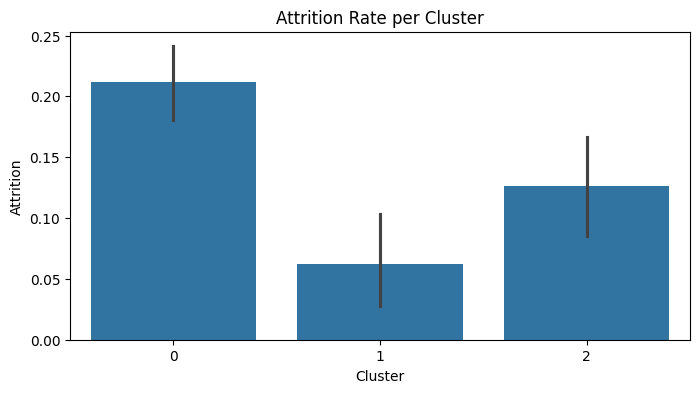

In [ ]:
# Analisis per cluster
plt.figure(figsize=(8,4))
sns.barplot(x='Cluster', y='Attrition', data=df, estimator=np.mean)
plt.title('Attrition Rate per Cluster')
plt.show()